### #### Copyright 2020.
**Author: H. Ngomseu Fotsing**

**Email: 217092052@student.uj.ac.za**

# Apple Leaves Disease Detection and Classification

In this notebook we will build on the model to classify 3 basic apple diseases (Apple_Scab, Black_rot, and Apple_Cedar_rust), in addition to the identifying the healthy leaves and improve accuracy by employing data augmentation

The Step in building are as follows:

1. Setting up libraries
2. Data collection and preprocessing.
3. Image classificaiton.
4. Loss and accuracy evaluation over the testing and training sets.

In [0]:
#importig the tensorflow library for data classification
import tensorflow as tf

## 1. Setting up Libraries
Importing necessary libraries for computing the data

In [0]:
#Importing libraries for data cleaning, segmentation and model classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt #For displaying the performance of the model

In [0]:
#installing the pyDrive library to access files from drive acount
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#authenticating the drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#loading the zip dataset file from the drive
fid = drive.ListFile({'q':"title='img_dataset_leafs.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('img_dataset_leafs.zip')

In [0]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

## 2. Data Extraction
Here we extract the data from img_dsease ip file in our google drive storage


In [0]:
#Extracting the images files(Unzipping)
!unzip img_dataset_leafs.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_dataset/train/Apple___healthy/13227870-bd81-48a1-97a0-8c5bcecef8f7___RS_HL 7452_90degFlipLR.JPG  
  inflating: img_dataset/train/Apple___healthy/13227870-bd81-48a1-97a0-8c5bcecef8f7___RS_HL 7452_90degFlipTB.JPG  
  inflating: img_dataset/train/Apple___healthy/13227870-bd81-48a1-97a0-8c5bcecef8f7___RS_HL 7452_FlipTB.JPG  
  inflating: img_dataset/train/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271.JPG  
  inflating: img_dataset/train/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271_90degFlipLR.JPG  
  inflating: img_dataset/train/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271_90degFlipTB.JPG  
  inflating: img_dataset/train/Apple___healthy/13298d36-4425-437d-ae8e-c7d70e200084___RS_HL 6271_FlipTB.JPG  
  inflating: img_dataset/train/Apple___healthy/1331fd38-acdf-488f-a5db-8dfcecfa5690___RS_HL 7381.JPG  
  inflating: img_dataset/train/Apple___healthy/1331fd38-acdf-48

In [0]:
PATH = 'img_dataset'

In [0]:
os.listdir(PATH)

['train', 'test']

In [0]:
#settingup the path of the traning and testing dataset
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

In [0]:
train_applescab_dir = os.path.join(train_dir, 'Apple___Apple_scab')  # directory with our training Apple_scab disease pictures
train_blackrot_dir = os.path.join(train_dir, 'Apple___Black_rot')  # directory with our training Apple___Black_rot disease pictures
train_cedarapplerust_dir = os.path.join(train_dir, 'Apple___Cedar_apple_rust')  # directory with our training Apple___Cedar_apple_rust disease pictures
train_healthy_dir = os.path.join(train_dir, 'Apple___healthy')  # directory with our training Apple___healthy disease pictures

validation_applescab_dir = os.path.join(validation_dir, 'Apple___Apple_scab')  # directory with our testing Apple___Apple_scab disease pictures
validation_blackrot_dir = os.path.join(validation_dir, 'Apple___Black_rot')  # directory with our testing Apple___Black_rot disease pictures
validation_cedarapplerust_dir = os.path.join(validation_dir, 'Apple___Cedar_apple_rust')  # directory with our training Apple___Cedar_apple_rust disease pictures
validation_healthy_dir = os.path.join(validation_dir, 'Apple___healthy')  # directory with our testing Apple___healthy disease pictures

In [0]:
#validating the dataset by evaluating the number of images
#Training set
num_applescab_tr = len(os.listdir(train_applescab_dir))
num_blackrot_tr = len(os.listdir(train_blackrot_dir))
num_cedarapplerust_tr = len(os.listdir(train_cedarapplerust_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))

#Testing set
num_applescab_val = len(os.listdir(validation_applescab_dir))
num_blackrot_val = len(os.listdir(validation_blackrot_dir))
num_cedarapplerust_val = len(os.listdir(validation_cedarapplerust_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))

#Evaluating total for testing and training set
total_train = num_applescab_tr + num_blackrot_tr + num_cedarapplerust_tr + num_healthy_tr
total_val = num_applescab_val + num_blackrot_val + num_cedarapplerust_val + num_healthy_val

In [0]:
#Displaying result
print('total training Apple___Apple_scab images:', num_applescab_tr)
print('total training Apple___Black_rot images:', num_blackrot_tr)
print('total training Apple___Cedar_apple_rust images:', num_cedarapplerust_tr)
print('total training Apple___healthy images:', num_healthy_tr)

print('total validation Apple___Apple_scab images:', num_applescab_val)
print('total validation Apple___Black_rot images:', num_blackrot_val)
print('total validation Apple___Cedar_apple_rust images:', num_cedarapplerust_val)
print('total Validation Apple___healthy images:', num_healthy_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Apple___Apple_scab images: 2017
total training Apple___Black_rot images: 1988
total training Apple___Cedar_apple_rust images: 880
total training Apple___healthy images: 5264
total validation Apple___Apple_scab images: 505
total validation Apple___Black_rot images: 496
total validation Apple___Cedar_apple_rust images: 220
total Validation Apple___healthy images: 1316
--
Total training images: 10149
Total validation images: 2537


###Data preprocessing
Rescaling data and storing in binary format for computation

In [0]:
#Initialising the model dimensions
batch_size = 128
epochs = 10
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [0]:
# Normalize pixel values to be between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
#Generating the training data from directory and formating it
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')


Found 10148 images belonging to 4 classes.


In [0]:
print(train_data_gen)

In [0]:
#generating the testing dataset from testing directory
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2536 images belonging to 4 classes.


In [0]:
#Storing the training images and it labels
sample_training_images, train_labels = next(train_data_gen)

## 3. Image Classification
We segment and label the training data that will be used for evaluation and testing

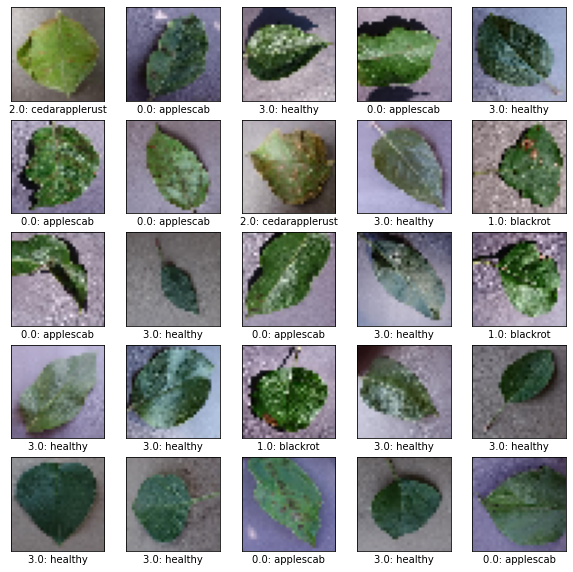

In [0]:
#Displaying a sample output for 25 images with labels from the dataset
class_names = ['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_training_images[i], cmap=plt.cm.binary)
    #plt.xlabel(str(train_labels[i]) + ': applescab')

    if(train_labels[i]==0.0):
      plt.xlabel(str(train_labels[i]) + ': applescab')
    elif(train_labels[i]==1.0):
      plt.xlabel(str(train_labels[i]) + ': blackrot')
    elif(train_labels[i]==2.0):
      plt.xlabel(str(train_labels[i]) + ': cedarapplerust')
    elif(train_labels[i]==3.0):
      plt.xlabel(str(train_labels[i]) + ': healthy')
plt.show()

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

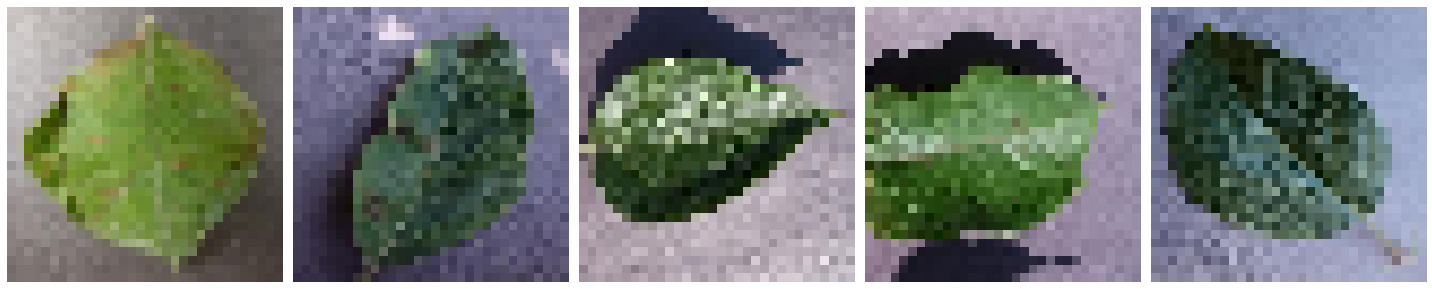

In [0]:
#Image segmentation
plotImages(sample_training_images[:5])

In [0]:
#setting up the model parameter with 3 convolutional layer and 2 denses
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
#generating the model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
79/79 [==============================] - 27s 343ms/step - loss: 1.1288 - accuracy: 0.5434 - val_loss: 0.8270 - val_accuracy: 0.6517
Epoch 2/10
79/79 [==============================] - 27s 341ms/step - loss: 0.7133 - accuracy: 0.7012 - val_loss: 0.6499 - val_accuracy: 0.7307
Epoch 3/10
79/79 [==============================] - 27s 341ms/step - loss: 0.5983 - accuracy: 0.7512 - val_loss: 0.5785 - val_accuracy: 0.7500
Epoch 4/10
79/79 [==============================] - 27s 342ms/step - loss: 0.5255 - accuracy: 0.7825 - val_loss: 0.4570 - val_accuracy: 0.8302
Epoch 5/10
79/79 [==============================] - 27s 341ms/step - loss: 0.4254 - accuracy: 0.8297 - val_loss: 0.3775 - val_accuracy: 0.8668
Epoch 6/10
79/79 [==============================] - 27s 341ms/step - loss: 0.3672 - accuracy: 0.8598 - val_loss: 0.3419 - val_accuracy: 0.8754
Epoch 7/10
79/79 [==============================] - 27s 341ms/step

## 4. Evaluating Loss and accuracy of training and Validation sets
Visual display of the performance, accuracy and loss using graphs 

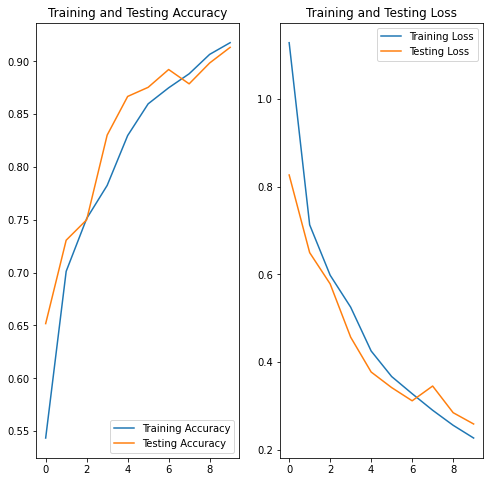

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()
plt.savefig('samplefigure1.png')
files.download('samplefigure1.png')

4/4 - 0s - loss: 0.1860 - accuracy: 0.9219


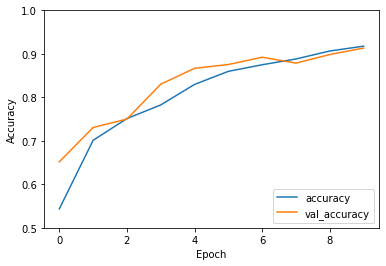

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('samplefigure.png')
files.download('samplefigure.png')

test_loss, test_acc = model.evaluate(sample_training_images,  train_labels, verbose=2)

In [0]:
print('Testing Accuracy: ' + str(test_acc))

Testing Accuracy: 0.921875
